# Publications Hypergraph Demo Notebook

This notebook is used to replcate the use case experiment in the paper **PAPER LINK HERE** that demonstrates the use of the hypergraph interchange formation (HIF).

The following hypergraph libraries have the HIF loading and saving functions allowing for the analysis of the same hypergraph over each library:
* HyperNetX (HNX)
* HyperGraphX (HGX)
* SimpleHypergraphs
* TopoNetX
* Hypergraph Analysis Toolbox (HAT)
* compleX Group Interactions (XGI)

## Publications Data as a Hypergraph

This dataset consists of open source publications with the keyword "Hypergraph" and was collected from ArXiv, Biorxiv, DBLP and Osti. The Hypergraph has hyperedges as publications and nodes as authors. The hyperedges have attributes including funding agencies, abstract, publication date, tags, and source, while the nodes have the attributes of institutions.

In [1]:
# import standard packages for analysis and plotting
import json

import matplotlib.pyplot as plt
import numpy as np

In [2]:
file_path = "data/publications.hif.json"
with open(file_path, "r") as f:
    HIF_publications = json.load(f)

# HyperNetX

Here we demo loading in the hypergraph using HNX and demoing the unique homology capabilities of the library.

In [5]:
import hypergraphx as hgx
import hypernetx as hnx
import xgi

In [6]:
H_hnx = hnx.from_hif(HIF_publications)
H_xgi = xgi.read_hif(file_path)

In [15]:
pos = xgi.pairwise_spring_layout(H_xgi)

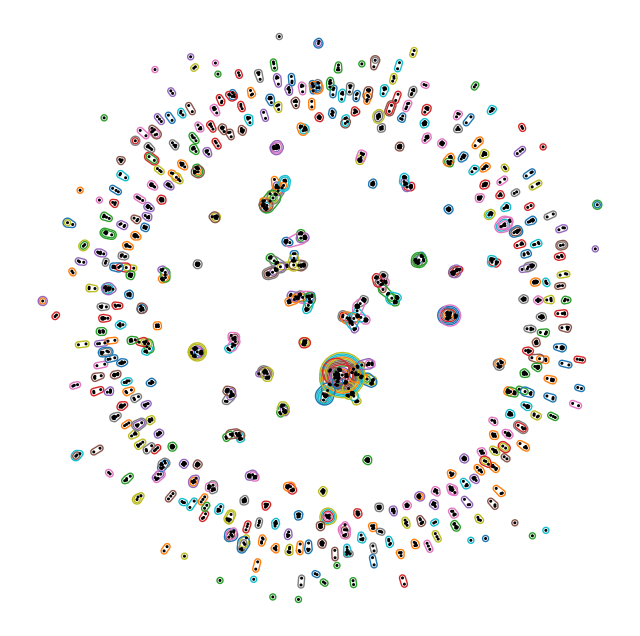

In [16]:
hnx.draw(
    H_hnx,
    pos=pos,
    with_edge_labels=False,
    with_node_labels=False,
    node_radius=0.2,
    edges_kwargs={"lw": 0.5},
)

In [17]:
# Getting the main connected component of hypergraph
import numpy as np

Hs = list(H_hnx.s_component_subgraphs(s=1, return_singletons=False))
I = np.argsort([len(H_CC.incidences.dataframe) for H_CC in Hs])
Hs = [Hs[i] for i in I]
H = Hs[-1]

In [ ]:
pos = hnx.draw(
    H,
    with_edge_labels=False,
    with_node_labels=True,
    node_radius=0.2,
    edges_kwargs={"lw": 0.5},
    return_pos=True,
)
plt.show()

## One-Dimensional Homology of a Hypergraph Using HNX

In [ ]:
import hypernetx as hnx
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm

# Assuming your hypergraph 'H' is already defined
s = 1
edge_centrality = hnx.s_closeness_centrality(H, s=s)

# Get the centrality values and the edges
edges = list(H.edges)
centrality_values = np.array([edge_centrality[e] for e in edges])

# Normalize the centrality values to the range [0, 1]
if centrality_values.size > 0:
    normalized_centrality = (centrality_values - np.min(centrality_values)) / (
        np.max(centrality_values) - np.min(centrality_values)
    )
else:
    normalized_centrality = np.array([])  # Handle the case of no edges

# Choose a colormap
cmap = cm.get_cmap("viridis")

# Map the normalized centrality values to colors
edge_colors = cmap(normalized_centrality)

# Create a dictionary to pass to edges_kwargs for coloring
edge_style = {}
for i, edge in enumerate(edges):
    if i < len(edge_colors):
        edge_style[edge] = edge_colors[i]

# Create the hypergraph plot
fig, ax = plt.subplots(figsize=(12, 8))
hnx.draw(
    H,
    pos=pos,
    with_edge_labels=False,
    with_node_labels=True,
    node_radius=0.2,
    edges_kwargs={"color": list(edge_style.values()), "lw": 2, "alpha": 0.5},
    ax=ax,
)

# Add the colorbar
sm = cm.ScalarMappable(
    cmap=cmap,
    norm=plt.Normalize(vmin=np.min(centrality_values), vmax=np.max(centrality_values)),
)
sm.set_array([])  # For older versions of matplotlib
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label(f"{s}-Closeness Centrality")

plt.show()

In [ ]:
s = 1
print(f"The {s}-closeness centrality of the edges in hypergraph H is:")
print("-" * 100)

d = hnx.s_closeness_centrality(H, s=s)
for e in H.edges:
    print(f"{e}: {d[e]}")

# Add your library here with an example of a unique functionality it provides...

# XGI

In [19]:
testH = H_xgi.cleanup(in_place=False)

/opt/homebrew/Caskroom/miniforge/base/envs/xgi/lib/python3.13/copy.py:88: DeprecationWarning: Pickle, copy, and deepcopy support will be removed from itertools in Python 3.14.
  rv = reductor(4)


(<Axes: >,
 (<matplotlib.collections.PathCollection at 0x168a93390>,
  <matplotlib.collections.LineCollection at 0x30c41ae90>))

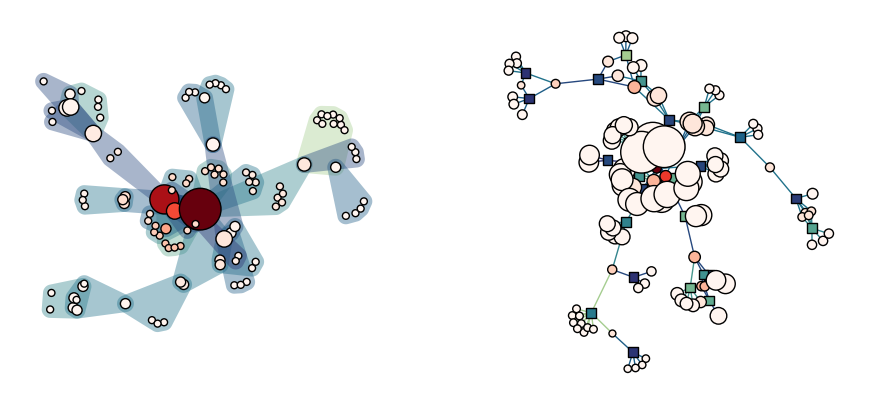

In [33]:
plt.figure(figsize=(11, 5))
plt.subplot(121)
xgi.draw(testH, hull=True, node_size=testH.nodes.degree, node_fc=testH.nodes.clique_eigenvector_centrality)
plt.subplot(122)
xgi.draw_bipartite(testH, node_fc=testH.nodes.degree, node_size=testH.nodes.average_neighbor_degree, edge_marker_fc=testH.edges.node_edge_centrality)

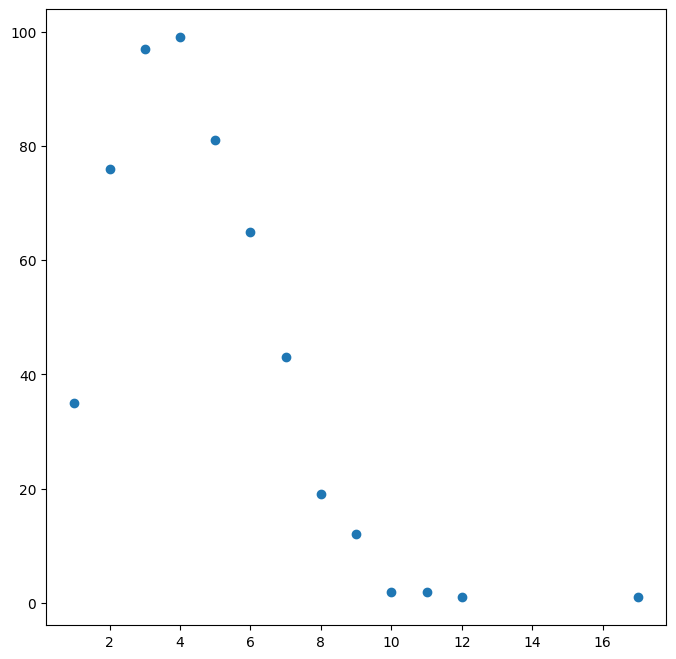

In [39]:
H_xgi.nodes.degree.argmax()
H_xgi.nodes.degree["Yue Gao"]
x, y = H_xgi.edges.size.unique(return_counts=True)
plt.scatter(x, y)